# Module 4: Assessing dog breeds for maximum social media outreach

This notebook attempts to shed light on the dog breeds most likely to attract maximum likes and retweets on twitter. For this, I have divided the notebook into **4 distinct sections**
1. Gathering
2. Assessing Data
3. Cleaning data
4. Analysis

This will be used in order to predict if a dog is likely to be popular on social media or not. Enough banter! Lets get on with the project.

## Table of Contents

1. [Gathering](#gathering)<br>
    1.1 [Importing Libraries](#importing)<br>
    1.2 [Importing Data](#data)<br>
2. [Assessing Data](#assessing)<br>
    2.1 [Quality](#quality)<br>
    2.2 [Tidiness](#tidy)<br>
3. [Cleaning Data](#cleaning)<br>
    3.1 [Quality](#qualclean)<br>
    3.2 [Tidiness](#tidyclean)<br>
4. [Analysis](#analyse)<br>
    4.1 [Fitting a Linear Model](#ml)<br>
    4.2 [Heatmaps for data](#heatmap)<br>

### 1. Gathering:-
<a id = "gathering"></a>
Data will be gathered via the following sources:-
1. From the `twitter_archive_enhanced.csv` file provided to us   
2. From `image_predictions.tsv` available to download
3. Using Tweepy to retrieve data about the likes, retweet count for a particular tweet id

#### 1.1) Import the essential libraries:
<a id="importing"></a>

In [10]:
import re
import numpy as np
import pandas as pd
from tqdm import tqdm
import requests
import os
import tweepy
import json
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#### 1.2) Importing data:
<a id = "data"></a>

a) Loading data from the `twitter-archive-enhanced.csv` file

In [11]:
dogs_df = pd.read_csv('twitter-archive-enhanced.csv')

b) Downloading and storing data for `image_predictions.tsv`

In [12]:
# Step 1: Downloading data
folder_name = 'Data_Files'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
with open(os.path.join(folder_name,url.split('/')[-1]), mode = 'wb') as file:
    file.write(response.content)

# Step 2: Reading data onto a dataframe
image_predictions = pd.read_csv('Data_Files/image-predictions.tsv', sep = '\t')
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


c) Using Tweepy for getting metadata on the tweets if available <br>
The information will be stored in `tweet_json.txt` present in the `Data_Files` directory from where the relevant fields can be read into a dataframe

In [13]:
# Retrieving data from twitter and storing in tweet_json.txt
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'

access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = tweepy.OAuthHandler(consumer_key,consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth,wait_on_rate_limit = True)

for tweet_id in tqdm(list(dogs_df.tweet_id)):
    try:
        json_format = api.get_status(tweet_id, tweet_mode = 'extended')._json
        json_format['tweet_id'] = tweet_id # although the json object contains an 'id' field, I added this to make referencing simpler for me
#         print(json_format['tweet_id'])
        with open("Data_Files/tweet_json.txt","a") as file:
            file.write(json.dumps(json_format))
            file.write("\n")
    except:
        pass

100%|██████████████████████████████████████████████████████████████████████████████| 2356/2356 [36:23<00:00,  1.08it/s]


In [14]:
# # Loading relevant fields from twet_json.txt and storing into a dataframe
# df_list = {'tweet_id': [], 'retweet_count':[],'favorite_count':[]}
df_list = []
with open("Data_Files/tweet_json.txt","r") as file:
    while True:
        json_string = file.readline()
        if len(json_string)!=0:
            df_list.append(json.loads(json_string))
        else:
            break

twitter_data = pd.DataFrame(df_list)
twitter_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 33 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   created_at                     2331 non-null   object 
 1   id                             2331 non-null   int64  
 2   id_str                         2331 non-null   object 
 3   full_text                      2331 non-null   object 
 4   truncated                      2331 non-null   bool   
 5   display_text_range             2331 non-null   object 
 6   entities                       2331 non-null   object 
 7   extended_entities              2059 non-null   object 
 8   source                         2331 non-null   object 
 9   in_reply_to_status_id          77 non-null     float64
 10  in_reply_to_status_id_str      77 non-null     object 
 11  in_reply_to_user_id            77 non-null     float64
 12  in_reply_to_user_id_str        77 non-null     o

### 2. Assessing Data:-
<a id="assessing"></a>

The rubric needs 8 quality issues and 2 tidiness issues to be documented. In this section, I will proceed to identify as many quality/tidiness issues that would be crucial to solve before analysis. <br>
Before proceeding with the assessment of data, I want to list the dataframes created so far and the information they capture
1. `dogs_df` which contains the basic information about the dogs in the dataframe - including but not limited to tweet id, rating, category, name, description,urls and so on
2. `image_prediction` which contains the top 3 predictions for the breed of the dog with the confidence of prediction
3. `twitter_data` which contains the retweets and likes garnered by the tweet.

Next I will create the common segment where the quality and tidiness issues will be stacked. This will be the single place we'll be returning to in case we want to refer issues later on.

##### Quality
<a id = 'quality'></a>
I) `dogs_df`
- [x] Some of the observations are retweets so need to be discarded. Filter out only those tweets that have an image url
- [x] `timestamp`, `retweeted_status_timestamp` columns should be of datatype `datetime`
- [x] We need to replace all `None` occurences with NaN to make the dataframe easy to work with
- [x] ~~`in_reply_to_status_id`,`in_reply_to_user_id` and the retweeted categories have a lot of missing values - can be retreived from the `tweet_json.txt` file if present~~
- [x] The ratings (`rating_numerator`) are indicated to be incorrect a lot of times. This can be corrected for.
- [x] Dog stages too are sometimes missing/sometimes incorrect and need to be corrected
- [x] ~~Dog names too can be looked at for inconsistencies (although we might need to examine the feasibility of this since this can be a pretty complex endeavour)~~ Can't be done with current knowledge (might need NLP knowledge)
- [x] Dog names are incorrectly identified (bizarre name "such" at index 23, or the name "quite", "an", "not", "one", "very", "O","just","old","life","officially", "space","light")

II) `image_prediction`
- [x] ~~Need to check for duplicate tweet id rows and consider the prediction confidence to choose which one to keep~~

III) `twitter_data`
- [x] ~~Need to check if any other columns can be added to the dataframe (Not a data cleaning task but rather a gathering task. Gather-Assess-Clean can be iterative!!!).~~ 

##### Tidiness
<a id="tidy"></a>
I) `dogs_df`
- [x] `doggo`,`floofer`,`pupper` and `puppo` should be under a single column `category`. One thing to note here that a single dog may be identified to belong to several categories
- [x] `text` column has information pertinent to other features too and needs to be cleaned as per rule - every variable should be in a new column


II) `image_prediction`
- [x] ~~Need this be a separate table? This upon examination does satisfy the condition for tidiness - each type of observational unit must be a table~~ This does not need to be a separate table


III) `twitter_data`
- [x] ~~Need this be a separate table? This needs to examined since maybe this may not satisfy the condition for tidiness - each type of observational unit must be a table~~ This does not need to be a separate table.

In [15]:
# Incorrect datatype for datetime related information. 
# Categories split into multiple columns

dogs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [16]:
# Check for retweets
print("Number of retweets: {}".format(dogs_df[dogs_df.retweeted_status_id.notnull()].shape[0]))

# Check for replies
temp = twitter_data[twitter_data.tweet_id.isin(dogs_df[dogs_df.in_reply_to_user_id.notnull()].tweet_id)].user
flag = 0
for i in range(temp.shape[0]):
    if re.search(r'WeRateDogs',temp.iloc[i]['name']):
        pass
    else:
        flag = 1
        print(temp.iloc[i]['name'])
        
if flag ==0:
    print("All replies by WeRateDogs. We will retain these")

Number of retweets: 181
All replies by WeRateDogs. We will retain these


In [17]:
# Other column information also present in text column

pd.set_option('display.max_colwidth', None)
dogs_df.text.head()

0                                                         This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU
1    This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV
2                     This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB
3                                                               This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ
4    This is Franklin. He would like you to stop calling him "cute." He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f
Name: text, dtype: object

In [18]:
# No duplicate tweet ids present
print("Number of duplicated records in dogs dataframe: {}".format(dogs_df.tweet_id.duplicated().sum()))

Number of duplicated records in dogs dataframe: 0


In [19]:
# Checking for rating mismatches

temp = dogs_df.text.str.extract(r'(((\d+\.\d+)|\d+)/((\d+\.\d+)|\d+))')[0].astype('str').str.split('/')
temp = pd.DataFrame(temp.to_list(), columns=['rating_numerator', 'rating_denominator'])
temp['rating_numerator'] = temp['rating_numerator'].astype('float')
temp['rating_denominator'] = temp['rating_denominator'].astype('float')
pd.set_option('display.max_colwidth', None)
temp[dogs_df['rating_numerator'] != temp['rating_numerator']]
print("Number of rating mismatches: {}".format(dogs_df[dogs_df['rating_numerator'] != temp['rating_numerator']].tweet_id.count()))
print("Number of metric mismatches: {}".format(dogs_df[dogs_df['rating_denominator'] != temp['rating_denominator']].tweet_id.count()))

Number of rating mismatches: 6
Number of metric mismatches: 0


In [20]:
# Checking for category mismatches

category_df = pd.DataFrame()
categories = ['doggo','floofer','pupper','puppo']
for category in categories:
    category_df[category] = dogs_df.text.str.lower().str.extract(r'({})'.format(category))[0]
# identify those columns where category is missed or does not match
print("Number of doggo misses: {}".format(dogs_df[(dogs_df.replace('None', '').doggo != category_df.fillna('').doggo)].tweet_id.count()))
print("Number of floofer misses: {}".format(dogs_df[(dogs_df.replace('None', '').floofer != category_df.fillna('').floofer)].tweet_id.count()))
print("Number of pupper misses: {}".format(dogs_df[(dogs_df.replace('None', '').pupper != category_df.fillna('').pupper)].tweet_id.count()))
print("Number of puppo misses: {}".format(dogs_df[(dogs_df.replace('None', '').puppo != category_df.fillna('').puppo)].tweet_id.count()))

Number of doggo misses: 10
Number of floofer misses: 0
Number of pupper misses: 26
Number of puppo misses: 8


In [26]:
# dogs_df.name.unique() an, not, one, very, O,just,old,life,officially, space,light - a common theme all of these have only small letters
print("Number of dogs for which name can be corrected: {}".format(dogs_df[dogs_df.name.str[0].str.isupper() == False].shape[0]))

Number of dogs for which name can be corrected: 109


In [27]:
# Checking for duplicate records

print("Number of duplicated records in image predictions: {}".format(image_predictions.tweet_id.duplicated().sum()))

Number of duplicated records in image predictions: 0


In [28]:
# Checking for features that might be useful for analysis

twitter_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 33 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   created_at                     2331 non-null   object 
 1   id                             2331 non-null   int64  
 2   id_str                         2331 non-null   object 
 3   full_text                      2331 non-null   object 
 4   truncated                      2331 non-null   bool   
 5   display_text_range             2331 non-null   object 
 6   entities                       2331 non-null   object 
 7   extended_entities              2059 non-null   object 
 8   source                         2331 non-null   object 
 9   in_reply_to_status_id          77 non-null     float64
 10  in_reply_to_status_id_str      77 non-null     object 
 11  in_reply_to_user_id            77 non-null     float64
 12  in_reply_to_user_id_str        77 non-null     o

Columns that can be identified to be useful for analysis:-
1. `retweet_count`
2. `favorite_count`

For considering whether or not the `image_predictions` dataframe can be a separate table, we can examine the features it seeks to capture

In [29]:
# Checking for whether image predictions needs to be a separate table

image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


Here, we can clearly see that aside from the primary key identifying the prediction with the image from a particular tweet, we have the the predictions and confidence level themselves of the top 3 predictions. We can thus conclude that the table should not stand by itself.

In [30]:
# Checking for whether twitter data needs to be a separate table

twitter_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 33 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   created_at                     2331 non-null   object 
 1   id                             2331 non-null   int64  
 2   id_str                         2331 non-null   object 
 3   full_text                      2331 non-null   object 
 4   truncated                      2331 non-null   bool   
 5   display_text_range             2331 non-null   object 
 6   entities                       2331 non-null   object 
 7   extended_entities              2059 non-null   object 
 8   source                         2331 non-null   object 
 9   in_reply_to_status_id          77 non-null     float64
 10  in_reply_to_status_id_str      77 non-null     object 
 11  in_reply_to_user_id            77 non-null     float64
 12  in_reply_to_user_id_str        77 non-null     o

Here we notice that this is the data from `dogs_df` itself with a few more features. So it can be safely merged with the `dogs_df` with the addition of our features of interest since it contains attributes of the tweets themselves (in perfect harmony with what `dogs_df` seeks to capture).

### 3. Cleaning Data:-
<a id = "cleaning"></a>

### 3.1) Quality
<a id='qualclean'></a>
Quality issues in data are resolved in this section

**Define** <br>
Retweets are to be removed. For this we can check `retweeted_status_id` columns and remove if not null. <br>
As already stated earlier, the replies are all from WeRateDogs and hence will be retained for analysis. <br>
I will also drop the 3 columns that captures retweet information since that is no longer required.

**Clean**

In [34]:
dogs_cleaned_df = dogs_df.copy()
dogs_cleaned_df = dogs_cleaned_df[dogs_cleaned_df.retweeted_status_id.isnull()].reset_index()

**Test**

In [36]:
print("Number of retweets in the cleaned dataframe: {}".format(dogs_cleaned_df.retweeted_status_id.notnull().sum()))
dogs_cleaned_df.drop(['retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp'], axis = 1, inplace=True)
dogs_cleaned_df.info()

Number of retweets in the cleaned dataframe: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2175 entries, 0 to 2174
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   index                  2175 non-null   int64  
 1   tweet_id               2175 non-null   int64  
 2   in_reply_to_status_id  78 non-null     float64
 3   in_reply_to_user_id    78 non-null     float64
 4   timestamp              2175 non-null   object 
 5   source                 2175 non-null   object 
 6   text                   2175 non-null   object 
 7   expanded_urls          2117 non-null   object 
 8   rating_numerator       2175 non-null   int64  
 9   rating_denominator     2175 non-null   int64  
 10  name                   2175 non-null   object 
 11  doggo                  2175 non-null   object 
 12  floofer                2175 non-null   object 
 13  pupper                 2175 non-null   object 
 14  puppo    

**Define** <br>
The `timestamp` column should be of datatype `datetime`

**Code**

In [37]:
dogs_cleaned_df['timestamp'] = pd.to_datetime(dogs_cleaned_df['timestamp'])

**Test**

In [38]:
dogs_cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2175 entries, 0 to 2174
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   index                  2175 non-null   int64              
 1   tweet_id               2175 non-null   int64              
 2   in_reply_to_status_id  78 non-null     float64            
 3   in_reply_to_user_id    78 non-null     float64            
 4   timestamp              2175 non-null   datetime64[ns, UTC]
 5   source                 2175 non-null   object             
 6   text                   2175 non-null   object             
 7   expanded_urls          2117 non-null   object             
 8   rating_numerator       2175 non-null   int64              
 9   rating_denominator     2175 non-null   int64              
 10  name                   2175 non-null   object             
 11  doggo                  2175 non-null   object           

**Define** <br>
Replace the null occurences with NaN. This will make it easier for us to work with the data in the later stages.

**Code**

In [40]:
dogs_cleaned_df = dogs_cleaned_df.replace('None',np.nan)

**Test**

In [41]:
dogs_cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2175 entries, 0 to 2174
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   index                  2175 non-null   int64              
 1   tweet_id               2175 non-null   int64              
 2   in_reply_to_status_id  78 non-null     float64            
 3   in_reply_to_user_id    78 non-null     float64            
 4   timestamp              2175 non-null   datetime64[ns, UTC]
 5   source                 2175 non-null   object             
 6   text                   2175 non-null   object             
 7   expanded_urls          2117 non-null   object             
 8   rating_numerator       2175 non-null   int64              
 9   rating_denominator     2175 non-null   int64              
 10  name                   1495 non-null   object             
 11  doggo                  87 non-null     object           

**Define** <br>
The ratings numerator and denominator needs to be corrected. This can be achieved by extracting the correct values from the cleaned dataframe. We will follow a similar process as one used in identifying that the rating values were incorrect. From the earlier analysis, we had concluded that there were 6 mismatches. However, it can be possible that this time around we may not have as many ratings mismatches in the cleaned dataframe as some rows have been dropped.

**Code**

In [42]:
temp = dogs_cleaned_df.text.str.extract(r'(((\d+\.\d+)|\d+)/((\d+\.\d+)|\d+))')[0].astype('str').str.split('/')
temp = pd.DataFrame(temp.to_list(), columns=['rating_numerator', 'rating_denominator'])
temp['rating_numerator'] = temp['rating_numerator'].astype('float')
temp['rating_denominator'] = temp['rating_denominator'].astype('float')
print("Number of rating mismatches: {}".format((dogs_cleaned_df.rating_numerator != temp.rating_numerator).sum()))
print("Number of metric mismatches: {}".format(dogs_cleaned_df[dogs_cleaned_df['rating_denominator'] != temp['rating_denominator']].tweet_id.count()))

Number of rating mismatches: 5
Number of metric mismatches: 0


As can be seen, number of mismatched ratings have reduced in the cleaned dataframe as one column that was overlapping in retweets and incorrect ratings is dropped. We can simply set the `rating_numerator` column in `dogs_cleaned_df` equal to `rating_numerator` column in `temp`

In [43]:
dogs_cleaned_df['rating_numerator'] = temp['rating_numerator']

**Test**

In [44]:
dogs_cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2175 entries, 0 to 2174
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   index                  2175 non-null   int64              
 1   tweet_id               2175 non-null   int64              
 2   in_reply_to_status_id  78 non-null     float64            
 3   in_reply_to_user_id    78 non-null     float64            
 4   timestamp              2175 non-null   datetime64[ns, UTC]
 5   source                 2175 non-null   object             
 6   text                   2175 non-null   object             
 7   expanded_urls          2117 non-null   object             
 8   rating_numerator       2175 non-null   float64            
 9   rating_denominator     2175 non-null   int64              
 10  name                   1495 non-null   object             
 11  doggo                  87 non-null     object           

**Define** <br>
Missing values for dog stages. This can be resolved by using the same regex expression as the one used in cleaning. However, we expect to observe some differences due to some rows being dropped in the earlier stages of the cleaning process

**Code**

In [45]:
category_df = pd.DataFrame()
categories = ['doggo','floofer','pupper','puppo']
for category in categories:
    category_df[category] = dogs_cleaned_df.text.str.lower().str.extract(r'({})'.format(category))[0]
# identify those columns where category is missed or does not match
print("Number of doggo misses: {}".format(dogs_cleaned_df[(dogs_cleaned_df.doggo.fillna('') != category_df.doggo.fillna(''))].tweet_id.count()))
print("Number of floofer misses: {}".format(dogs_cleaned_df[(dogs_cleaned_df.floofer.fillna('') != category_df.floofer.fillna(''))].tweet_id.count()))
print("Number of pupper misses: {}".format(dogs_cleaned_df[(dogs_cleaned_df.pupper.fillna('') != category_df.pupper.fillna(''))].tweet_id.count()))
print("Number of puppo misses: {}".format(dogs_cleaned_df[(dogs_cleaned_df.puppo.fillna('') != category_df.puppo.fillna(''))].tweet_id.count()))

Number of doggo misses: 8
Number of floofer misses: 0
Number of pupper misses: 26
Number of puppo misses: 8


It can be seen that the number of misses in `doggo` has reduced resulting from dropping rows during the earlier stages of cleaning to mitigate retweets from skewing our analysis. To correct for this we can simply update the `doggo`,`floofer` (although no misses but for the sake of completeness we can carry this one over), `pupper` and `puppo`

In [46]:
for category in categories:
    dogs_cleaned_df[category] = category_df[category]

**Test**

In [47]:
print("Number of doggo misses: {}".format(dogs_cleaned_df[(dogs_cleaned_df.doggo.fillna('') != category_df.doggo.fillna(''))].tweet_id.count()))
print("Number of floofer misses: {}".format(dogs_cleaned_df[(dogs_cleaned_df.floofer.fillna('') != category_df.floofer.fillna(''))].tweet_id.count()))
print("Number of pupper misses: {}".format(dogs_cleaned_df[(dogs_cleaned_df.pupper.fillna('') != category_df.pupper.fillna(''))].tweet_id.count()))
print("Number of puppo misses: {}".format(dogs_cleaned_df[(dogs_cleaned_df.puppo.fillna('') != category_df.puppo.fillna(''))].tweet_id.count()))

Number of doggo misses: 0
Number of floofer misses: 0
Number of pupper misses: 0
Number of puppo misses: 0


**Define** <br>
The names of some dogs have been incorrectly identified. We can set these names to NaN (we could have tried some NLP library for NER but since currently I don't have the requisite knowledge, we will try this in a future iteration)

**Code**

In [48]:
inc_names = list(dogs_cleaned_df[dogs_cleaned_df.name.str[0].str.isupper() == False].name.unique())
print("Incorrectly identified names: {}".format(inc_names))

Incorrectly identified names: ['such', 'a', 'quite', 'not', 'one', 'incredibly', 'very', 'my', 'his', 'an', 'actually', 'just', 'getting', 'mad', 'this', 'unacceptable', 'all', 'old', 'infuriating', 'the', 'by', 'officially', 'life', 'light', 'space']


In [49]:
mask = dogs_cleaned_df['name'].isin(inc_names)
dogs_cleaned_df.loc[mask,'name'] = np.nan

**Test**

In [50]:
print("Incorrectly identified names: {}".format(list(dogs_cleaned_df[dogs_cleaned_df.name.str[0].str.isupper() == False].name.unique())))

Incorrectly identified names: []


Thus we have removed incorrect names from the cleaned dataframe.

### 3.2) Tidiness
<a id='tidyclean'></a>
Tidiness issues have been resolved in this section.

**Define** <br>
`doggo`,`floofer`,`pupper` and `puppo` should be under a single column category. One thing to note here that a single dog may be identified to belong to several categories. We will create another column `category` to capture this information and drop the other columns. This might not be the most elegant solution (Duh! It runs in O($n^2$)) but it works (the .melt function was driving me nuts). Note that here we're putting back 'Unidentified' in place of NaN. This is so as to maintain some consistency in datatype of the column

**Code**

In [51]:
category_list = []
for i in range(dogs_cleaned_df.shape[0]):
    temp_list = dogs_cleaned_df.iloc[i,-4:]
    cat_row = []
    for j in temp_list:
        if pd.isna(j) == False:
            cat_row.append(j)
    if len(cat_row)==0:
        category_list.append(['Unidentified'])
    else:
        category_list.append(cat_row)

In [52]:
dogs_cleaned_df['category'] = category_list
dogs_cleaned_tidied = dogs_cleaned_df.drop(categories, axis = 1)

**Test**

In [55]:
print("[[Unidentified],[pupper],[doggo],[puppo],[doggo,puppo],[floofer],[doggo, puppo],[doggo,floofer]]:\n{}".format(list(dogs_cleaned_tidied.category.value_counts())))

[[Unidentified],[pupper],[doggo],[puppo],[doggo,puppo],[floofer],[doggo, puppo],[doggo,floofer]]:
[1790, 250, 82, 31, 10, 9, 2, 1]


**Define** <br>
`text` column in `dogs_df` has information pertinent to other features too and needs to be cleaned as per rule - every variable should be in a new column. Since there's two parts - one the rating and two the link, both of which will not appear as discrete words (ie not have spaces) and both contain numbers, we can simply filter for the segments that do not contain numeric characters. This may however lead to some loss of context and incomplete sentences since a lot of places ratings are included as parts of a sentence.
This might however be unavoidable.

**Code**

In [56]:
dogs_cleaned_tidied.text = dogs_cleaned_tidied.text.str.extract(r'(\D+)')

**Test**

In [57]:
dogs_cleaned_tidied

,index,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,category
0,0,892420643555336193,NaN,NaN,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut.,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13.0,10,Phineas,[Unidentified]
1,1,892177421306343426,NaN,NaN,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit.",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,10,Tilly,[Unidentified]
2,2,891815181378084864,NaN,NaN,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike.,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12.0,10,Archie,[Unidentified]
3,3,891689557279858688,NaN,NaN,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal.,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13.0,10,Darla,[Unidentified]
4,4,891327558926688256,NaN,NaN,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such.","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12.0,10,Franklin,[Unidentified]
...,...,...,...,...,...,...,...,...,...,...,...,...
2170,2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a,https://twitter.com/dog_rates/status/666049248165822465/photo/1,5.0,10,NaN,[Unidentified]
2171,2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron.,https://twitter.com/dog_rates/status/666044226329800704/photo/1,6.0,10,NaN,[Unidentified]
2172,2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue.,https://twitter.com/dog_rates/status/666033412701032449/photo/1,9.0,10,NaN,[Unidentified]
2173,2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a western brown Mitsubishi terrier. Upset about leaf. Actually,https://twitter.com/dog_rates/status/666029285002620928/photo/1,7.0,10,NaN,[Unidentified]


**Define** <br>
`twitter_data` does not need to be a separate table since it contains information and metadata of the tweets which is precisely what `dogs_df` seeks to capture. We'll be using the merge function to join the columns we are interested in - `favorite_count` and `retweet_count`. We will also merge `image_predictions` table with the resultant quantity.

**Code**

In [58]:
metadata_twitter_data = twitter_data[['tweet_id','retweet_count','favorite_count']].copy()
dogs_cleaned_tidied = dogs_cleaned_tidied.merge(metadata_twitter_data, how = "inner",on = "tweet_id")
dogs_cleaned_tidied = dogs_cleaned_tidied.merge(image_predictions, how = 'inner', on = 'tweet_id')

**Test**

In [59]:
dogs_cleaned_tidied.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1987 entries, 0 to 1986
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   index                  1987 non-null   int64              
 1   tweet_id               1987 non-null   int64              
 2   in_reply_to_status_id  23 non-null     float64            
 3   in_reply_to_user_id    23 non-null     float64            
 4   timestamp              1987 non-null   datetime64[ns, UTC]
 5   source                 1987 non-null   object             
 6   text                   1987 non-null   object             
 7   expanded_urls          1987 non-null   object             
 8   rating_numerator       1987 non-null   float64            
 9   rating_denominator     1987 non-null   int64              
 10  name                   1343 non-null   object             
 11  category               1987 non-null   object           

Here we observe that the number of tweets has dropped by a lot (almost halved from what we started with!!!). However, this is very much needed since this is the only way we can evaluate metrics for our analysis. Ideally at this stage we would go back to gathering more data for our analysis but the limitation we have - dog breed predictions are available only for tweet id's present in the given dataset prevents me from doing so. 

Finally we store the cleaned and tidied dataframe into `twitter_archive_master.csv`

In [60]:
dogs_cleaned_tidied.to_csv('twitter_archive_master.csv', index = False)

### 4. Analysis:-
<a id = 'analyse'></a>

In this section, I will devise a method to predict how many `favorite_count`s a dog of a given breed is likely to get based on the breed, confidence level of predictions and rating. I'll also do a similar analysis for `retweet_count`. Before we get started with building a model, it should be instructive to see how many unique values exist for a particular prediction column. This will give us an insight into whether an effective model can even be constructed in the first place. This will be followed up by the model itself in case I find that building a model is viable. Note that in our analysis, although I plan to take a product of confidence of prediction and the dummy columns that I'll generate for every breed, a better metric than simple multiplication might be the need of the dataset (that I won't correct for but it could be taken up in the future maybe?). Another limitation results from the presence of predictions other than dog breed in the dataset. I certainly can't correct for this so we'll let these other predictions also be present in our model (Hopefully they won't affect the quality of our predictions about ratings!!)

In [61]:
pred_df = dogs_cleaned_tidied.copy()
pred_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1987 entries, 0 to 1986
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   index                  1987 non-null   int64              
 1   tweet_id               1987 non-null   int64              
 2   in_reply_to_status_id  23 non-null     float64            
 3   in_reply_to_user_id    23 non-null     float64            
 4   timestamp              1987 non-null   datetime64[ns, UTC]
 5   source                 1987 non-null   object             
 6   text                   1987 non-null   object             
 7   expanded_urls          1987 non-null   object             
 8   rating_numerator       1987 non-null   float64            
 9   rating_denominator     1987 non-null   int64              
 10  name                   1343 non-null   object             
 11  category               1987 non-null   object           

In [62]:
print("Number of unique predictions: {} ".format(len(list(pd.get_dummies(pred_df.p1).columns))))

Number of unique predictions: 374 


Thus we can say that any kind of model we build on top of these predictions would not be a good one since we don't have significant number of observations for a particular breeds/predictions. We can however, try analysing the top predictions appearing in the dataframe. Through this we can get an estimate of what breeds tend to get submitted to WeRateDogs. We can use this to build a flawed yet functional estimator for the metric we desire to obtain. Note that we will no longer use `p2` and `p3` but presume `p1` to be true. This modification is necessitated by the observation that there are too many unique predictions in `p2` and `p3` for their results to be statiscally significant. This is the billionth time I wish we had more observations and less variability!!  

In [63]:
mask = pred_df.p1.value_counts().sort_values(ascending=False).head(10).index
top_10_breeds = pred_df.loc[pred_df.p1.isin(mask),:].reset_index()
print("Number of unique predictions in p2:{}\nNumber of unique predictions in p3:{}".format(top_10_breeds.p2.nunique(),top_10_breeds.p3.nunique()))

Number of unique predictions in p2:121
Number of unique predictions in p3:137


In [64]:
top_10_breeds[list(pd.get_dummies(top_10_breeds.p1).columns)] = pd.get_dummies(top_10_breeds.p1)
top_10_breeds.drop('index', axis = 1, inplace =True)
top_10_breeds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 637 entries, 0 to 636
Data columns (total 35 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   level_0                637 non-null    int64              
 1   tweet_id               637 non-null    int64              
 2   in_reply_to_status_id  5 non-null      float64            
 3   in_reply_to_user_id    5 non-null      float64            
 4   timestamp              637 non-null    datetime64[ns, UTC]
 5   source                 637 non-null    object             
 6   text                   637 non-null    object             
 7   expanded_urls          637 non-null    object             
 8   rating_numerator       637 non-null    float64            
 9   rating_denominator     637 non-null    int64              
 10  name                   444 non-null    object             
 11  category               637 non-null    object             

Here I will take `toy_poodle` as the baseline variable. The features planned to be included in our analysis are:
1. `absolute_ratings` which is `rating_numerator`/`rating_denominator`
2. Dog breeds with toy poodle as the baseline variable
3. Categories that the dog is presumed to belong to. This might be slightly tricky to get correctly. I will assume wherever missing, the category to be 'Unidentified'. Furthermore, I will assume that any dog *has* to belong to two categories - with the possibility of both being 'Unidentified'. This will make it difficult to scale in case we happen to find a tweet where 3 categories are identified in the future.

Here we'll transform `category` into a form that makes it better for us to manipulate for analysis.

In [65]:
# top_10_breeds.category
for i in range(top_10_breeds.shape[0]):
    if len(top_10_breeds.iloc[i,11]) == 1:
        top_10_breeds.iloc[i,11].append('Unidentified')
    else:
        pass

In [67]:
temp = pd.DataFrame(top_10_breeds.category.to_list(), columns=['category_1', 'category_2'])

There might now be a whole debate about how the model needs to be indifferent to `column_1` and `column_2`. We can avert any difference in weights by randomly swapping values between the two columns. It hasn't been done in the adjoining segments but it is an option for the future. In fact, it can be argued that perhaps the value of category that comes first is more important than the one that follows (purely by observing the `text`). This is a discussion for another time though

In [68]:
top_10_breeds['category_1'] = temp['category_1']
top_10_breeds['category_2'] = temp['category_2']

I can now create the necessary dummy columns and then proceed to create the model

In [69]:
top_10_breeds[list(top_10_breeds.category_1.value_counts().index +"_1")] = pd.get_dummies(top_10_breeds.category_1)
top_10_breeds[list(top_10_breeds.category_2.value_counts().index +"_2")] = pd.get_dummies(top_10_breeds.category_2)
top_10_breeds['absolute_ratings'] = top_10_breeds.rating_numerator/top_10_breeds.rating_denominator
top_10_breeds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 637 entries, 0 to 636
Data columns (total 46 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   level_0                637 non-null    int64              
 1   tweet_id               637 non-null    int64              
 2   in_reply_to_status_id  5 non-null      float64            
 3   in_reply_to_user_id    5 non-null      float64            
 4   timestamp              637 non-null    datetime64[ns, UTC]
 5   source                 637 non-null    object             
 6   text                   637 non-null    object             
 7   expanded_urls          637 non-null    object             
 8   rating_numerator       637 non-null    float64            
 9   rating_denominator     637 non-null    int64              
 10  name                   444 non-null    object             
 11  category               637 non-null    object             

### 4.1) Fitting the Machine Learning Model
<a id = 'ml'></a>

I'll be fitting a simple linear regression. More complex models are obviously possible but I haven't a clue in implementing them in python. So we'll only draw very simple conclusions based on the results

In [71]:
top_10_breeds['intercept'] = 1
params = list(top_10_breeds.iloc[:,-22:].columns)
params = [i for i in params if i not in ['toy_poodle','category_1','category_2','Unidentified_1','Unidentified_2']]
lm = sm.OLS(top_10_breeds['favorite_count'], top_10_breeds[params])
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         favorite_count   R-squared:                       0.159
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     7.352
Date:                Mon, 21 Jun 2021   Prob (F-statistic):           7.24e-16
Time:                        16:28:09   Log-Likelihood:                -6862.0
No. Observations:                 637   AIC:                         1.376e+04
Df Residuals:                     620   BIC:                         1.383e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Chihuahua           2560.9704   2334.648      1.097      0.273   -2023.806    7145.747
Labrador_retriever  3723.4424   2281.231      1.632      0.103    -756.434    8203.319
Pembroke            3316.1377   2295.036      1.445      0.149   -1190.848    7823.124
Pomeranian           740.4927   2709.206      0.273      0.785   -4579.840    6060.826
Samoyed             4461.3787   2703.463      1.650      0.099    -847.675    9770.433
chow                1599.6771   2665.695      0.600      0.549   -3635.208    6834.563
golden_retriever    2857.4568   2184.752      1.308      0.191   -1432.953    7147.867
malamute            2163.8879   2906.585      0.744      0.457   -3544.056    7871.832
pug                 1471.3051   2506.525      0.587      0.557   -3451.002    6393.613
pupper_1            1.181e+04   2768.912      4.266      0.000    6374.096    1.72e+04
doggo_1             2640.6055   5324.957      0.496      0.620   -7816.531    1.31e+04
puppo_1            -2509.2087   1480.441     -1.695      0.091   -5416.494     398.077
floofer_1           4395.7144   4472.080      0.983      0.326   -4386.545    1.32e+04
pupper_2           -6219.9595   5899.288     -1.054      0.292   -1.78e+04    5365.048
puppo_2            -1.048e+04    1.2e+04     -0.872      0.384   -3.41e+04    1.31e+04
absolute_ratings    2.251e+04   2718.453      8.280      0.000    1.72e+04    2.78e+04
intercept          -1.898e+04   3573.523     -5.311      0.000    -2.6e+04    -1.2e+04
==============================================================================
Omnibus:                      600.486   Durbin-Watson:                   1.586
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            30560.655
Skew:                           4.053   Prob(JB):                         0.00
Kurtosis:                      35.950   Cond. No.                         40.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Most of the p values are above the alpha value (assumed 5% in this case). This means we cannot reject the null hypothesis that breeds other than `pug`, categories other than `Unidentified's` result in greater favorite counts. We can however roughly gauge which features are negatively and positively correlated with the dependent variable with respect to the baseline. This inabilility to draw conclusions stems from the fact that we don't have enough data 

Similarly, we can fit a regression line for `retweet_count`.

In [72]:
lm = sm.OLS(top_10_breeds['retweet_count'], top_10_breeds[params])
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          retweet_count   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     4.318
Date:                Mon, 21 Jun 2021   Prob (F-statistic):           4.51e-08
Time:                        16:28:47   Log-Likelihood:                -6251.4
No. Observations:                 637   AIC:                         1.254e+04
Df Residuals:                     620   BIC:                         1.261e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Chihuahua            471.4157    895.240      0.527      0.599   -1286.654    2229.485
Labrador_retriever   877.3844    874.756      1.003      0.316    -840.460    2595.229
Pembroke             338.7462    880.050      0.385      0.700   -1389.494    2066.986
Pomeranian            36.3127   1038.867      0.035      0.972   -2003.811    2076.437
Samoyed             1257.2360   1036.664      1.213      0.226    -778.563    3293.035
chow                   9.2441   1022.182      0.009      0.993   -1998.115    2016.603
golden_retriever     300.2546    837.760      0.358      0.720   -1344.937    1945.447
malamute             204.3838   1114.553      0.183      0.855   -1984.373    2393.140
pug                    7.7364    961.147      0.008      0.994   -1879.762    1895.234
pupper_1            4861.3571   1061.761      4.579      0.000    2776.273    6946.442
doggo_1             1746.9002   2041.897      0.856      0.393   -2262.972    5756.773
puppo_1             -368.7116    567.687     -0.649      0.516   -1483.533     746.110
floofer_1            197.1897   1714.855      0.115      0.908   -3170.438    3564.817
pupper_2           -2893.2706   2262.129     -1.279      0.201   -7335.634    1549.093
puppo_2            -5207.0652   4609.864     -1.130      0.259   -1.43e+04    3845.774
absolute_ratings    5850.1718   1042.412      5.612      0.000    3803.085    7897.259
intercept          -4431.7698   1370.296     -3.234      0.001   -7122.754   -1740.786
==============================================================================
Omnibus:                      920.850   Durbin-Watson:                   1.894
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           248730.478
Skew:                           7.789   Prob(JB):                         0.00
Kurtosis:                      98.544   Cond. No.                         40.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Here again, results are not statistically significant due to the same reasons

### Visualizing Heatmaps of Data Based on Dog Breed and Category
<a id = 'heatmap'></a>

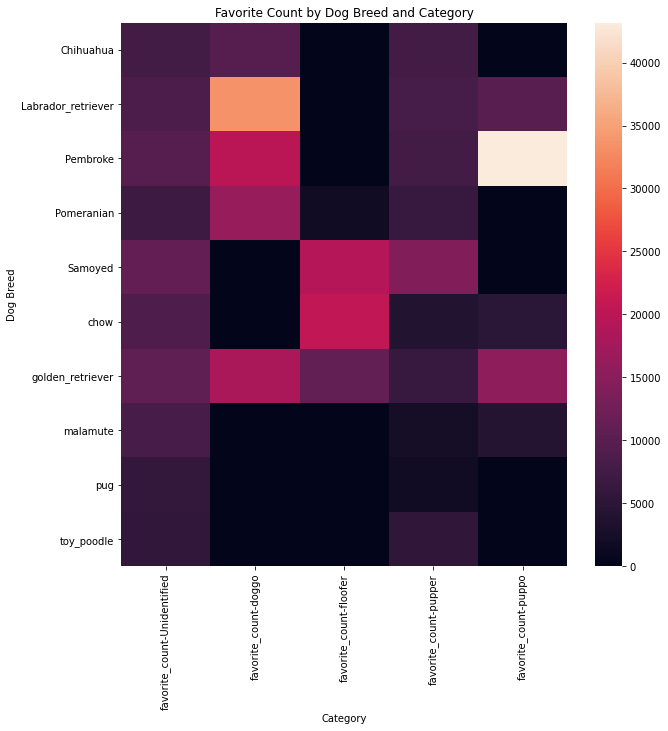

In [73]:
pvt_db_cat = pd.pivot_table(top_10_breeds, values = ['favorite_count'], index = ['p1'], columns = ['category_1'], aggfunc = np.mean)
pvt_db_cat.fillna(0, inplace = True)

sns.color_palette("magma")
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(pvt_db_cat);
plt.xlabel("Category");
plt.ylabel("Dog Breed");
plt.title("Favorite Count by Dog Breed and Category");

Here we can observe that `Pembroke` in the `puppo` stage receives maximum number of likes. `Labrador Retriever` in `doggo` stage receives considerable likes. The safest option to go by is the `Golden Retriever` since it receives consistent favorites throughout its stages

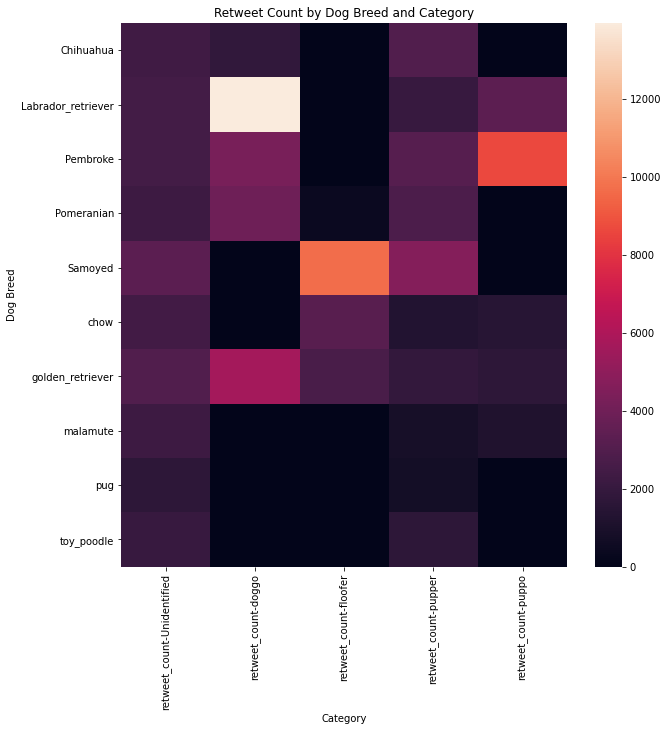

In [74]:
pvt_db_cat = pd.pivot_table(top_10_breeds, values = ['retweet_count'], index = ['p1'], columns = ['category_1'], aggfunc = np.mean)
pvt_db_cat.fillna(0, inplace = True)

sns.color_palette("magma")
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(pvt_db_cat);
plt.xlabel("Category");
plt.ylabel("Dog Breed");
plt.title("Retweet Count by Dog Breed and Category");

Similar stats are observed for `retweet_count` suggesting that `retweet_count` and `favorite_count` are positively correlated (pretty intuitive). Here as well `Golden Retriever` does consistently well across all its stages and `Labrador retriever` and `Pembroke` acheive high status in the `pupper` and `puppo` stages respectively. One may attribute the drop in performance of other dog breeds in specific stages to a lack of data for those breeds in those stages. This is a perfectly valid observation. 